In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp
import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py

In [3]:
log_file = pd.read_csv("run_set_1/log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,a,b,w,n_runs,ts
0,40,1587,0.1,0.105,2.25,560,1679976101
1,40,1587,0.1,0.105,2.20,560,1679976171
2,40,1587,0.1,0.105,2.30,560,1679977141
3,40,1587,0.1,0.105,2.35,560,1679977238
4,40,1587,0.1,0.105,2.40,560,1679978238
5,40,1587,0.1,0.105,2.45,560,1679978285
6,40,1587,0.1,0.105,2.50,560,1679979293
7,40,1587,0.1,0.105,2.55,560,1679979363
8,40,1587,0.1,0.105,2.60,560,1679980389
9,40,1587,0.1,0.105,2.65,560,1679980404


In [3]:
def generate_corr_matrix(reverse_dict, L):
    vect = np.zeros(shape=(L*L, L*L), dtype=bool)
    for key in reverse_dict:
        if reverse_dict[key] is None: continue
        vect[key,reverse_dict[key]] = True
    return np.einsum('ab,ac->bc', vect, vect)

def generate_corr_matrix_alt(clust_dict, L):
    corr_mat_alt = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        for j in range(i, L*L):
            corr_mat_alt[i,j] = (clust_dict[i]==clust_dict[j])
    corr_mat_alt = corr_mat_alt.T + corr_mat_alt 
    return corr_mat_alt

def generate_corr_matrix_alt2(clust_dict, reverse_dict, L):
    #Fastest
    corr_mat = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        corr_mat[i, reverse_dict[clust_dict[i]]] = True
    return corr_mat

def power_law(x, scale, power):
    return 1/(1+x*scale)**power

In [ ]:
##### LEGACY CODE  ######
with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)


    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp = core_pair[0]
        reverse_list_temp = core_pair[1]
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    mean_corr_mat = np.zeros(shape=(L*L,L*L))
    for instance in range(len(reverse_dict_list)):
        mean_corr_mat += generate_corr_matrix_alt2(clust_dict_list[instance], reverse_dict_list[instance], L)
    
    mean_corr_mat = mean_corr_mat/n_runs_list[index]


In [5]:
L = 70


fixed_length_slice = log_file[lambda df: (df['L'] == L)]
ts_list = fixed_length_slice['ts'].tolist()
w_vals = fixed_length_slice['w'].tolist()
n_runs_list = fixed_length_slice['n_runs'].tolist()

mean_corr_mat_list = []

for index, ts in enumerate(ts_list):
    
    
    with open("run_set_1/Ising_2D_cmat_"+str(ts)+".pkl", "rb") as fp:   
        c_mat = pickle.load(fp)
        
    mean_corr_mat_list.append(c_mat)
    

/home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py:95: RuntimeWarning: divide by zero encountered in power
  return x**(-a)


0.6142839993993569
0.5838682521819876
0.6444035873257531
0.6848305065885328
0.7272131322040413
0.7831584251490302
0.8424317977897344
0.9113425586613995
1.0001937784620103
1.1065643894839552
1.2189253092367456
1.3038505926628758


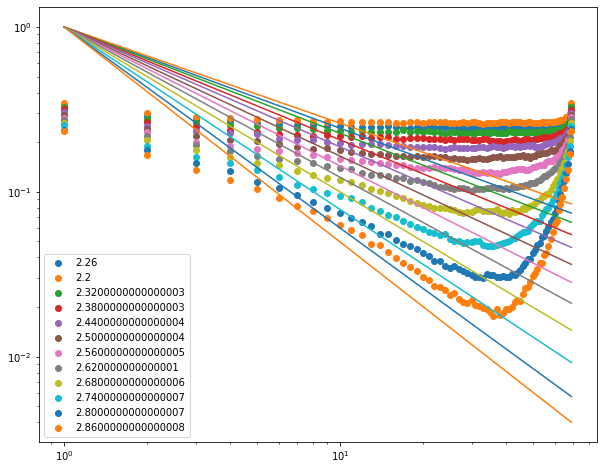

In [6]:
plt.figure(figsize=(10,8))

for index, w in enumerate(w_vals):
    if not index%1==0: continue
    mean_corr_mat = mean_corr_mat_list[index]
    y_vals = np.arange(L)
    corr_function = np.zeros(shape=(L))

    for y in range(L):
        for x in range(L):
            corr_function[y] += mean_corr_mat[index_map(0,x,L), index_map(y,x,L)]

    plt.scatter(y_vals, corr_function/L, label=str(w))

    popt, pcov = curve_fit(power_law, y_vals[4:20],corr_function[4:20]/L)

    plt.plot(y_vals, power_law(y_vals, *popt))
    print(*popt)

plt.legend()
#plt.xlim(0, 20)
plt.xscale('log')
plt.yscale('log')

In [11]:
ts = 1681168497

with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)


clust_dict_list, reverse_dict_list = [], []

for core_pair in clust_list_final:
    clust_list_temp = core_pair[0]
    reverse_list_temp = core_pair[1]
    clust_dict_list+=clust_list_temp
    reverse_dict_list+=reverse_list_temp

t0 = time.time()
corr_mat_alt2 = generate_corr_matrix_alt2(clust_dict_list[0], reverse_dict_list[0], 50)
print(time.time()-t0)

0.08069372177124023
